# Convert Bylot forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [2]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Bylot Island, Canadian high Arctic

The site is a low-center polygon, with herb tundra and no erect vegetation

| Short name | byl |
|:-----------|:----|
| Location | 73.1504ºN, 80.0046ºW |
| Elevation | 25 m |
| Snow-free albedo | - |
| Simulation period | 11 July 2013 to 25 June 2019 |
| Temperature/humidity measurement height | 2.3 m |
| Wind measurement height | 2.3 m |
| Reference | Domine et al. ([2021](https://essd.copernicus.org/articles/13/4331/2021/)) |

In [3]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'

year_start = '2013'
year_end = '2019'

lat = 73.1504
lon = -80.0046

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/byl already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/byl/forcing already exist.


### Open original forcing file

In [4]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 52202)
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...
Data variables:
    Wind     (time) float64 418kB ...
    Tair     (time) float64 418kB ...
    Qair     (time) float64 418kB ...
    LWdown   (time) float64 418kB ...
    SWdown   (time) float64 418kB ...
    Psurf    (time) float64 418kB ...
    Rainf    (time) float64 418kB ...
    Snowf    (time) float64 418kB ...

## Repalce Snowf by snd

In [5]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
y_start = 2013
y_end = 2019
ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_met = xr.open_dataset(path_obs+'/met_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()

ds_h_obs

<xarray.Dataset> Size: 10MB
Dimensions:         (time: 52202, sdepth: 5, sheight: 10)
Coordinates:
  * time            (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-...
  * sdepth          (sdepth) float64 40B 0.02 0.05 0.1 0.15 0.21
  * sheight         (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.27 0.35 0.37
Data variables:
    snd_auto        (time) float64 418kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    albs            (time) float64 418kB 0.16 0.15 0.17 0.16 ... 0.17 0.16 0.16
    flag_albs_ERA5  (time) int64 418kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ts              (time) float64 418kB 9.86 10.42 13.45 ... 10.71 14.89 nan
    mrsll           (sdepth, time) float64 2MB 0.2 0.2 0.2 ... 0.066 0.066 0.066
    tsl             (sdepth, time) float64 2MB 3.7 4.3 4.99 ... -0.3 -0.3 -0.3
    tsnl            (sheight, time) float64 4MB nan nan nan nan ... nan nan nan
Attributes:
    reference:    Domine, F., Lackner, G., Sarrazin, D., Poirier, M., & Belke...
    description:  Converted to netCDF (SnowMIP kind of format) from original ...

<a list of 1 Line2D objects>

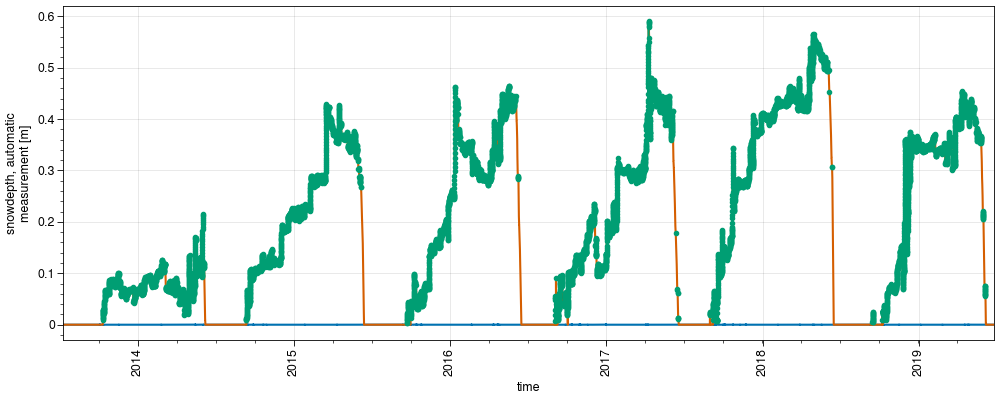

In [6]:
%matplotlib widget
pplt.subplots(figsize=(10,4))
ds.Snowf.plot()
ds_h_obs.snd_auto.plot()
ds_h_obs.snd_auto[1:].where( (ds_h_obs.snd_auto[1:].values-ds_h_obs.snd_auto[:-1].values) > 0).plot(marker='.')
# test.plot()

In [7]:
increasing_ds_h_obs = ds_h_obs.snd_auto[1:].where( (ds_h_obs.snd_auto[1:].values-ds_h_obs.snd_auto[:-1].values) > 0)
snowf_from_snd_temp = increasing_ds_h_obs.copy()

i = 0
while i < increasing_ds_h_obs.size:
    value = increasing_ds_h_obs.values[i]
    if not np.isnan(value):
        # i for ds_h_obs is alread i-1 because test start at 1
        snowf_from_snd_temp[i] = increasing_ds_h_obs.values[i]-ds_h_obs.snd_auto.values[i] 
    i += 1

<a list of 1 Line2D objects>

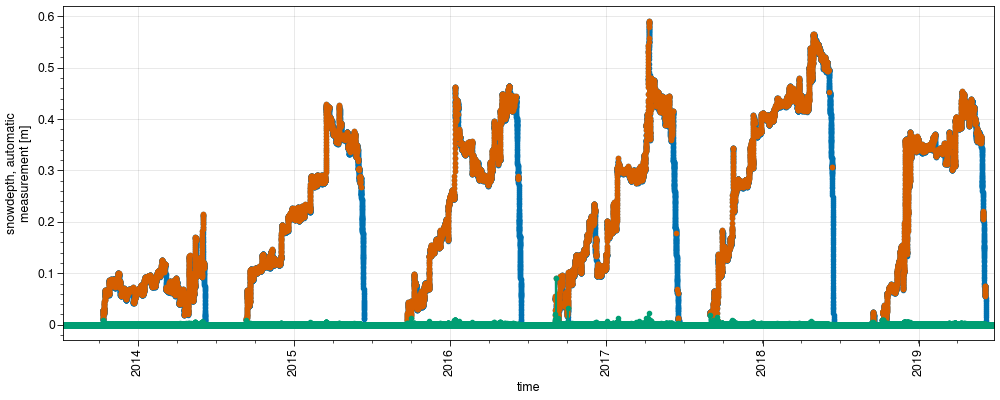

In [8]:
%matplotlib widget
pplt.subplots(figsize=(10,4))
ds_h_obs.snd_auto.plot(marker='.')
ds_h_obs.snd_auto[1:].where( (ds_h_obs.snd_auto[1:].values-ds_h_obs.snd_auto[:-1].values) > 0).plot(marker='.')
snowf_from_snd_temp.fillna(0).plot(marker='.')

<a list of 1 Line2D objects>

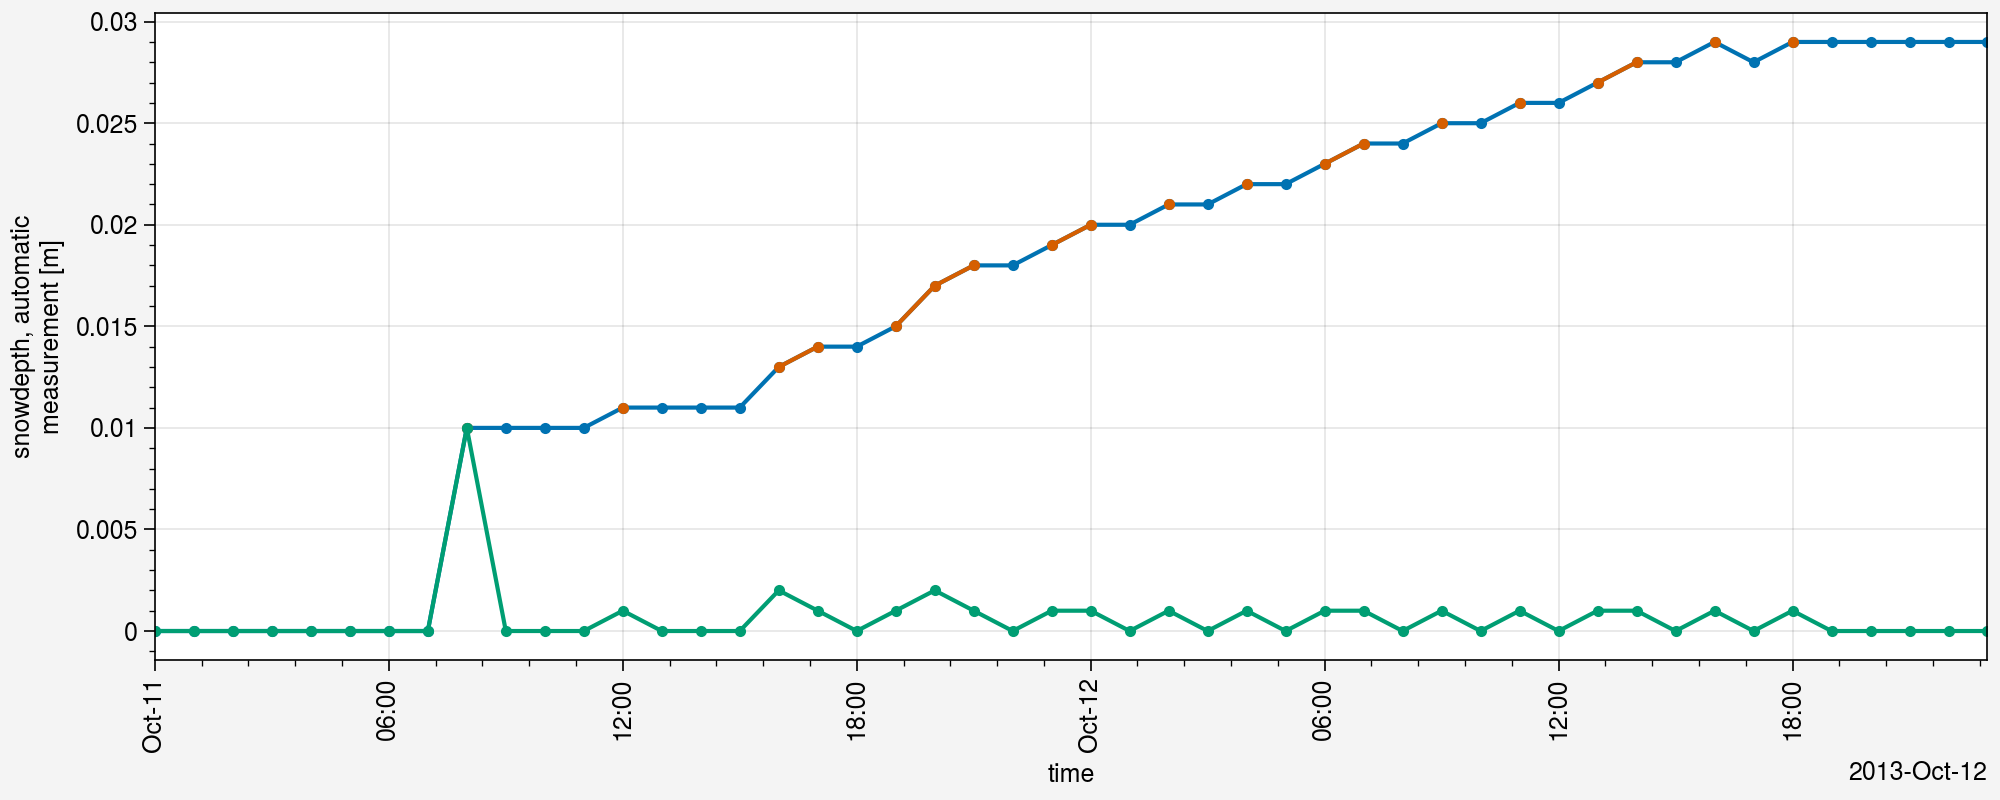

In [9]:
%matplotlib inline
period = slice('2013-10-11', '2013-10-12')
pplt.subplots(figsize=(10,4))
ds_h_obs.snd_auto.sel(time=period).plot(marker='.')
ds_h_obs.snd_auto[1:].where( (ds_h_obs.snd_auto[1:].values-ds_h_obs.snd_auto[:-1].values) > 0).sel(time=period).plot(marker='.')
snowf_from_snd_temp.fillna(0).sel(time=period).plot(marker='.')

### Convert to precipitation rates

https://cccma.gitlab.io/classic/atmosphericVarsCalc_8f90.html

```
if (TA(I) <= TFREZ) then
      RHOSNI(I) = 67.92 + 51.25 * EXP((TA(I) - TFREZ) / 2.59) 
    else
      RHOSNI(I) = MIN((119.17 + 20.0 * (TA(I) - TFREZ)),200.0)
    end if
```


In [10]:
ds.Tair.values

array([ 6.8199535 ,  6.95764435,  8.92526895, ..., 10.744     ,
       10.433     ,  9.186     ])

In [11]:
# T in °C
def compute_rho_new(ds_tas):
    # Tair < 0°C
    rho_new_neg = 67.92 + 51.25 * np.exp(ds_tas.where(ds_tas < 0) / 2.59)

    # Tair >= 0°C
    temp = 119.17 + 20.0 * ds_tas.where(ds_tas >= 0)
    rho_new_pos = temp.where(temp < 200, other=200).where(ds.Tair >= 0)

    # Combine
    rho_new = rho_new_neg.fillna(rho_new_pos)
    
    return rho_new

In [13]:
rho_new = compute_rho_new(ds.Tair)
rho_new

<xarray.DataArray 'Tair' (time: 52202)> Size: 418kB
array([200., 200., 200., ..., 200., 200., 200.])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

<a list of 1 Line2D objects>

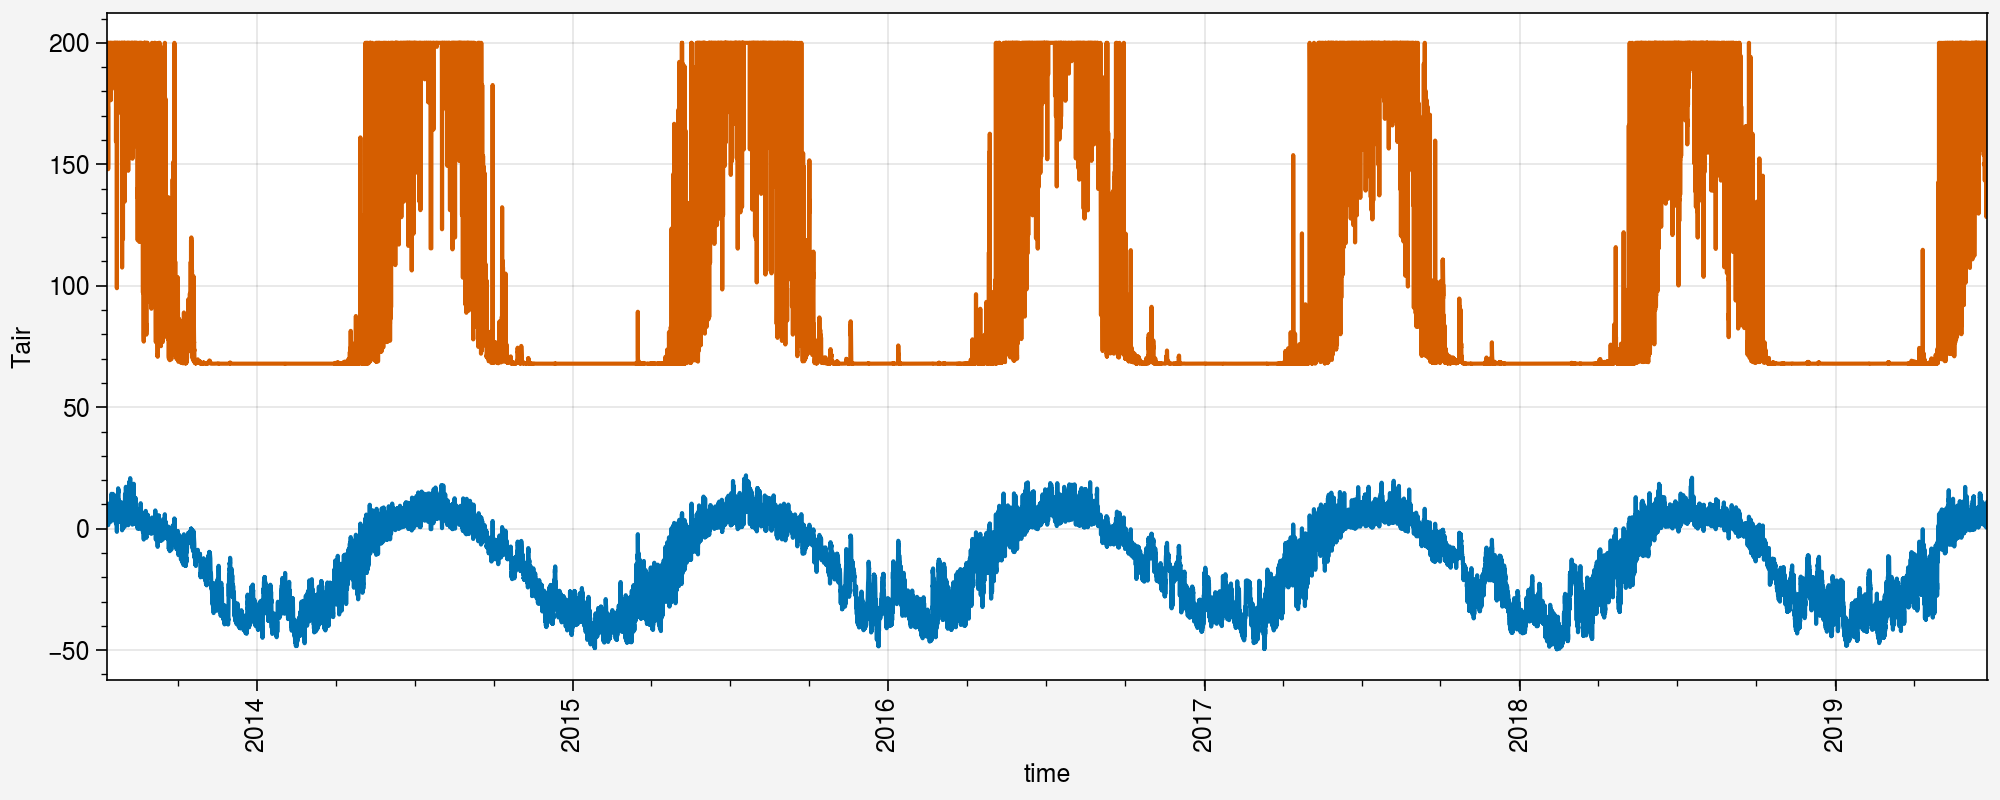

In [14]:
%matplotlib inline
pplt.subplots(figsize=(10,4))
ds.Tair.plot()
rho_new.plot()

In [18]:
snowf_from_snd = ds.Snowf.copy()
temp = ds.Snowf.copy()
temp[1:] = snowf_from_snd_temp.fillna(0)[:]
snowf_from_snd = temp * rho_new / 3600 # Convert to mm/s
snowf_from_snd

<xarray.DataArray (time: 52202)> Size: 418kB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

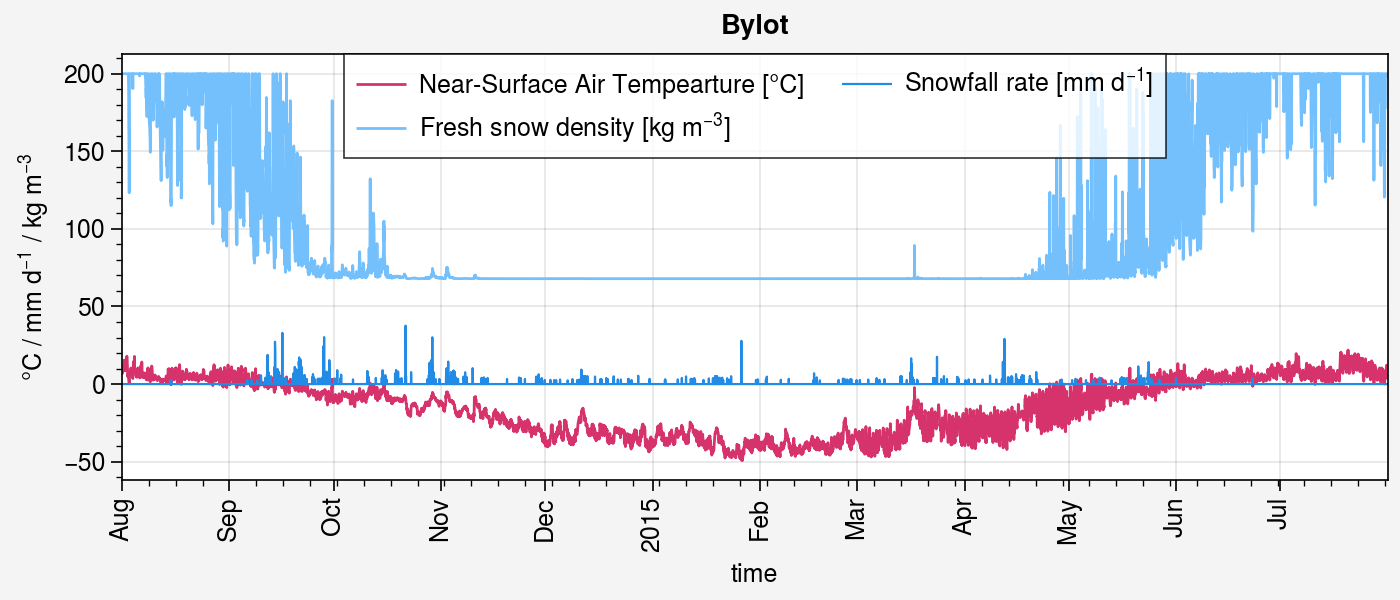

In [70]:
%matplotlib inline
period=slice('2014-08','2015-07')
fig, axs = pplt.subplots(figsize=(7,3))
ds.sel(time=period).Tair.plot(label='Near-Surface Air Tempearture [°C]', c='pink7', lw=1)
(ds.sel(time=period).Snowf*86400).plot(label='Snowfall rate [mm d$^{-1}$]', c='blue6', lw=0.8)
# (snowf_from_snd.sel(time=period)*1e6).plot()
rho_new.sel(time=period).plot(label='Fresh snow density [kg m$^{-3}$]', c='blue3', lw=1)
axs[0].format(ylabel='°C / mm d$^{-1}$ / kg m$^{-3}$')
axs[0].legend(ncols=2)
fig.suptitle('Bylot')
fig.save('ex_fresh_snow_density_bylot.jpg')

## Example of snow cover fraction plot

In [102]:
np.linspace(0, 0.2, 11)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

In [103]:
def compute_scf(sd):
    
    if sd > 0.1:
        scf = 1
    else:
        scf = sd/0.1
    return scf

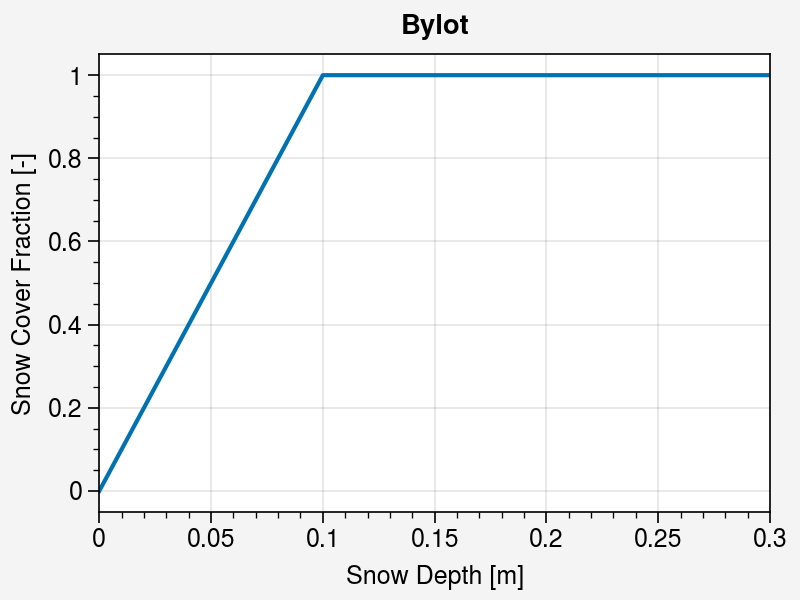

In [124]:
sd = np.linspace(0, 0.3, 100)
scf = [compute_scf(k) for k in sd]

%matplotlib inline
fig, axs = pplt.subplots(figsize=(4,3))
axs[0].plot(sd, scf)
axs[0].format(ylabel='Snow Cover Fraction [-]', xlabel='Snow Depth [m]')
# axs[0].legend(ncols=2)
fig.suptitle('Bylot')
fig.save('ex_scf.jpg')

<a list of 1 Line2D objects>

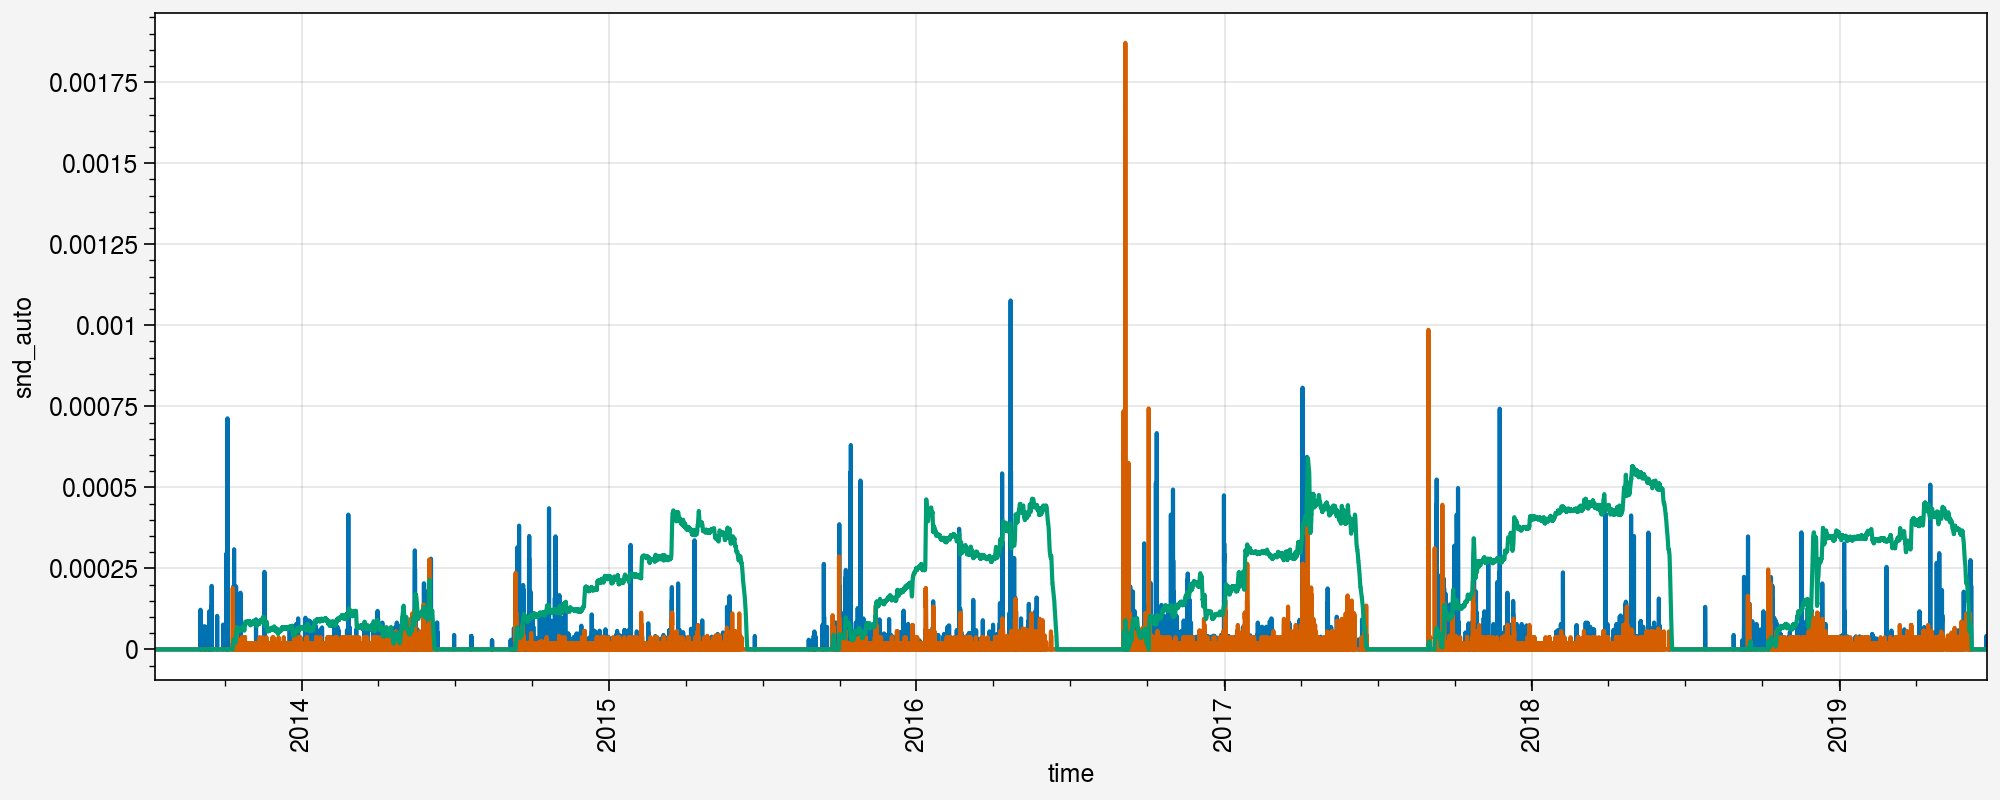

In [196]:
%matplotlib inline
pplt.subplots(figsize=(10,4))
ds.Snowf.plot()
snowf_from_snd.plot()
(ds_h_obs.snd_auto/1000).plot()

<a list of 1 Line2D objects>

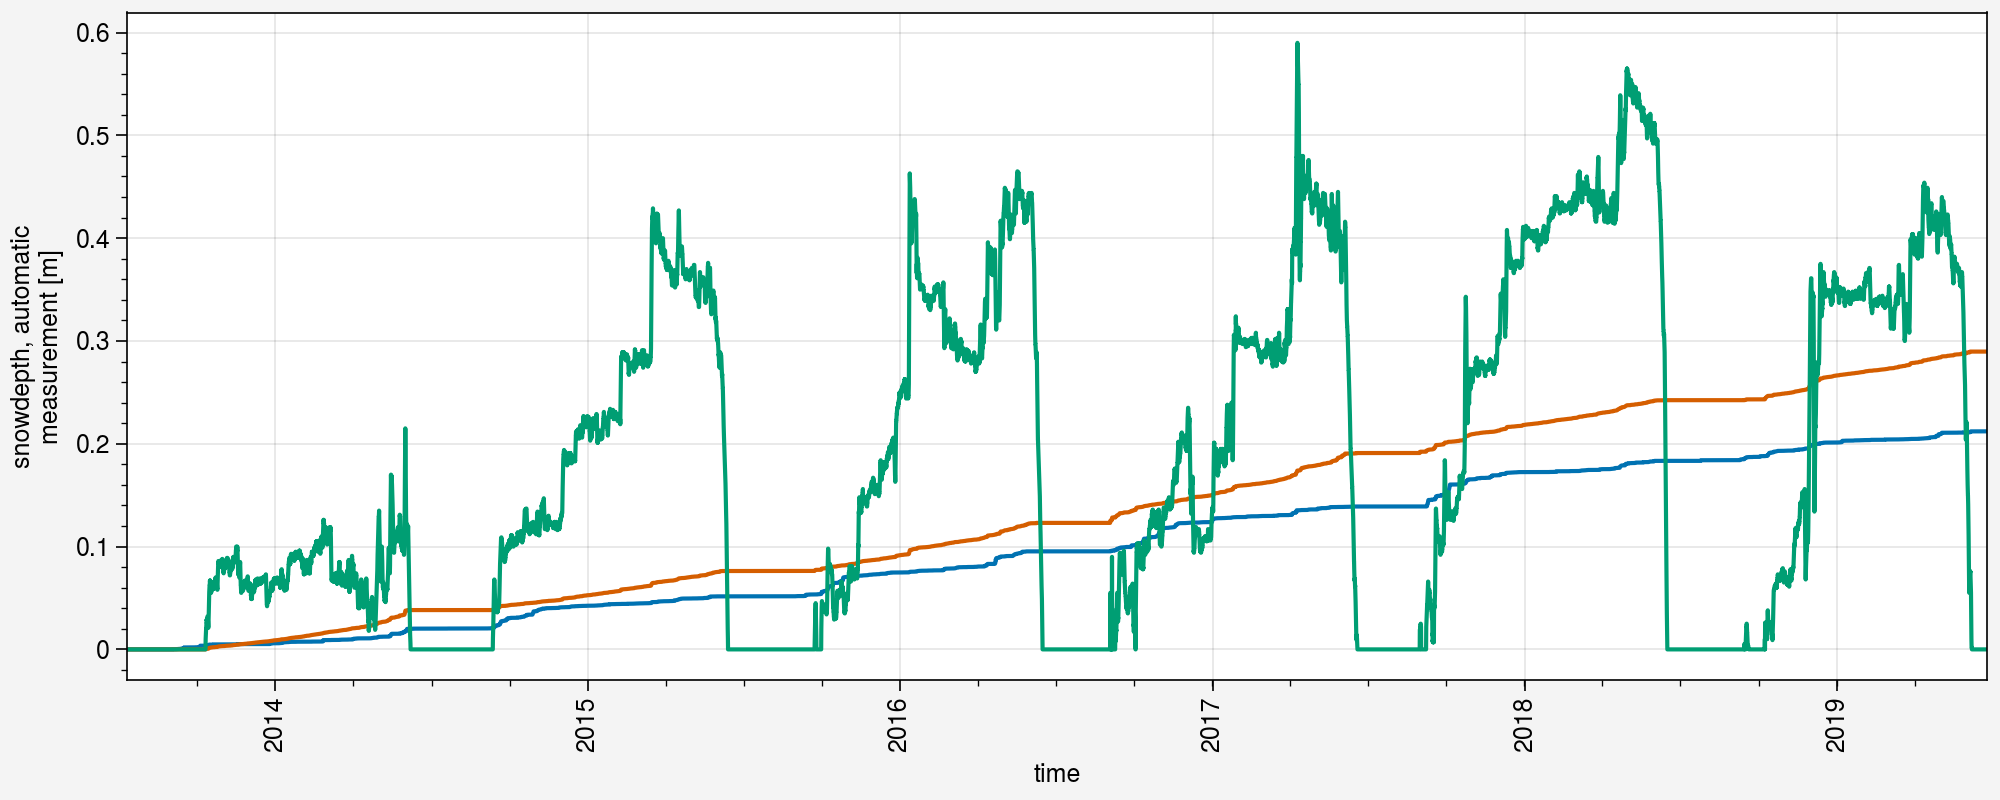

In [199]:
%matplotlib inline
pplt.subplots(figsize=(10,4))
ds.Snowf.cumsum().plot()
snowf_from_snd.cumsum().plot()
ds_h_obs.snd_auto.plot()

In [201]:
snowf_from_snd

<xarray.DataArray (time: 52202)> Size: 418kB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

<a list of 1 Line2D objects>

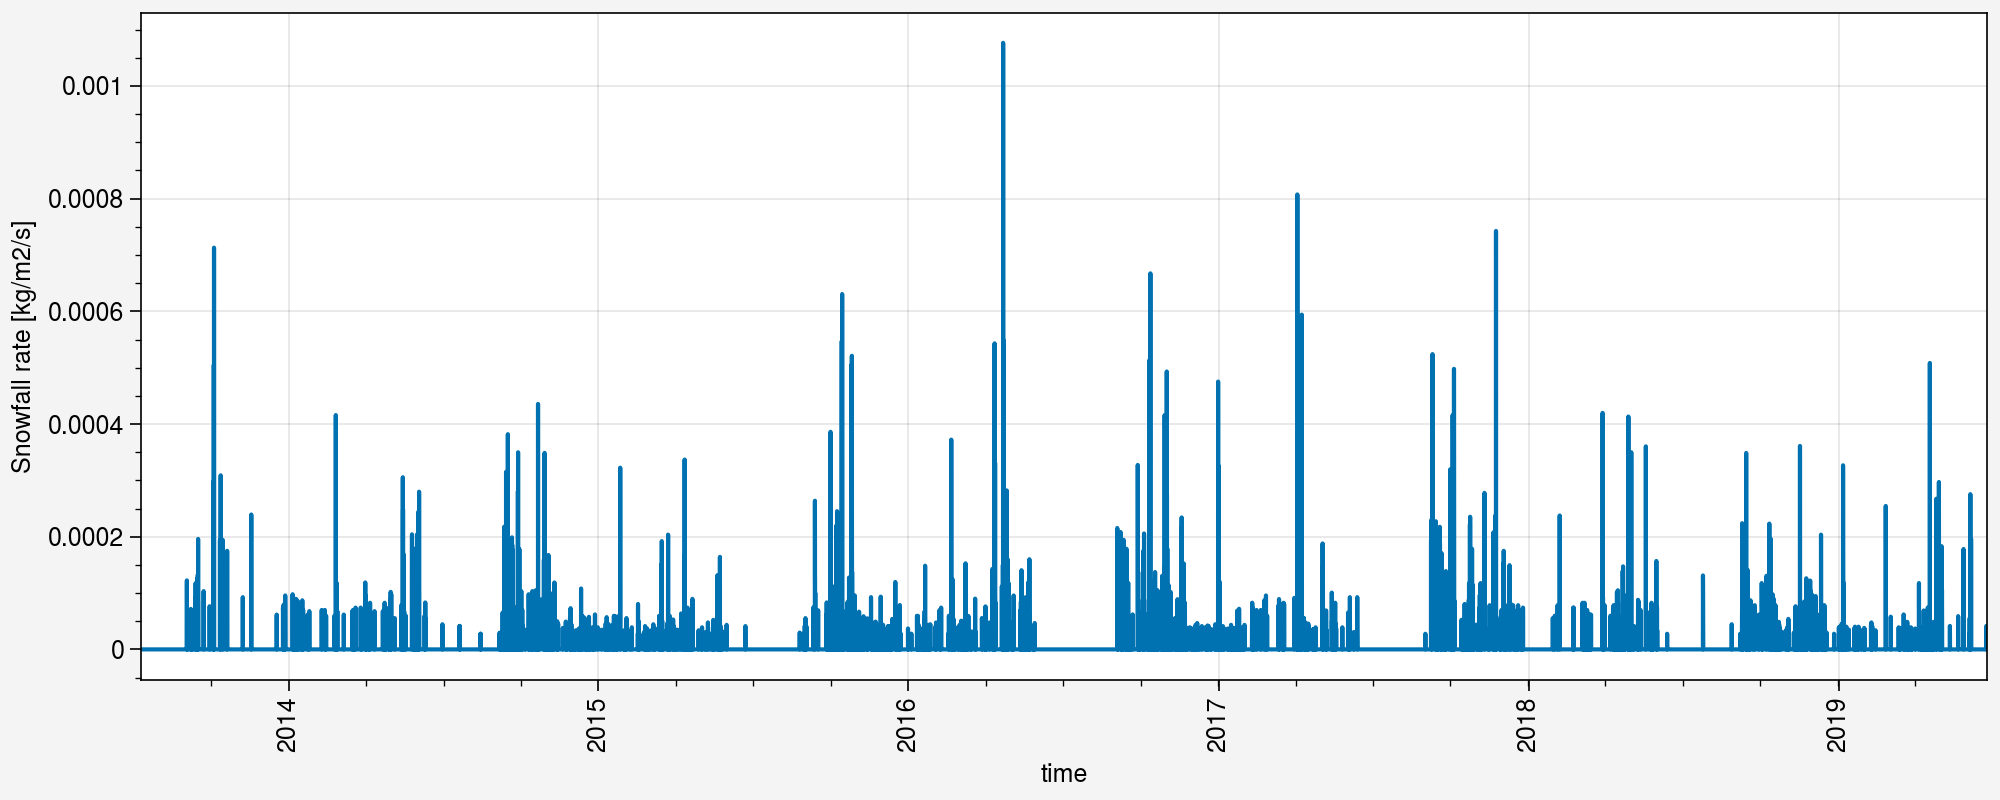

In [203]:
%matplotlib inline
pplt.subplots(figsize=(10,4))
ds.Snowf.plot()

In [204]:
ds.Snowf[:] = snowf_from_snd

<a list of 1 Line2D objects>

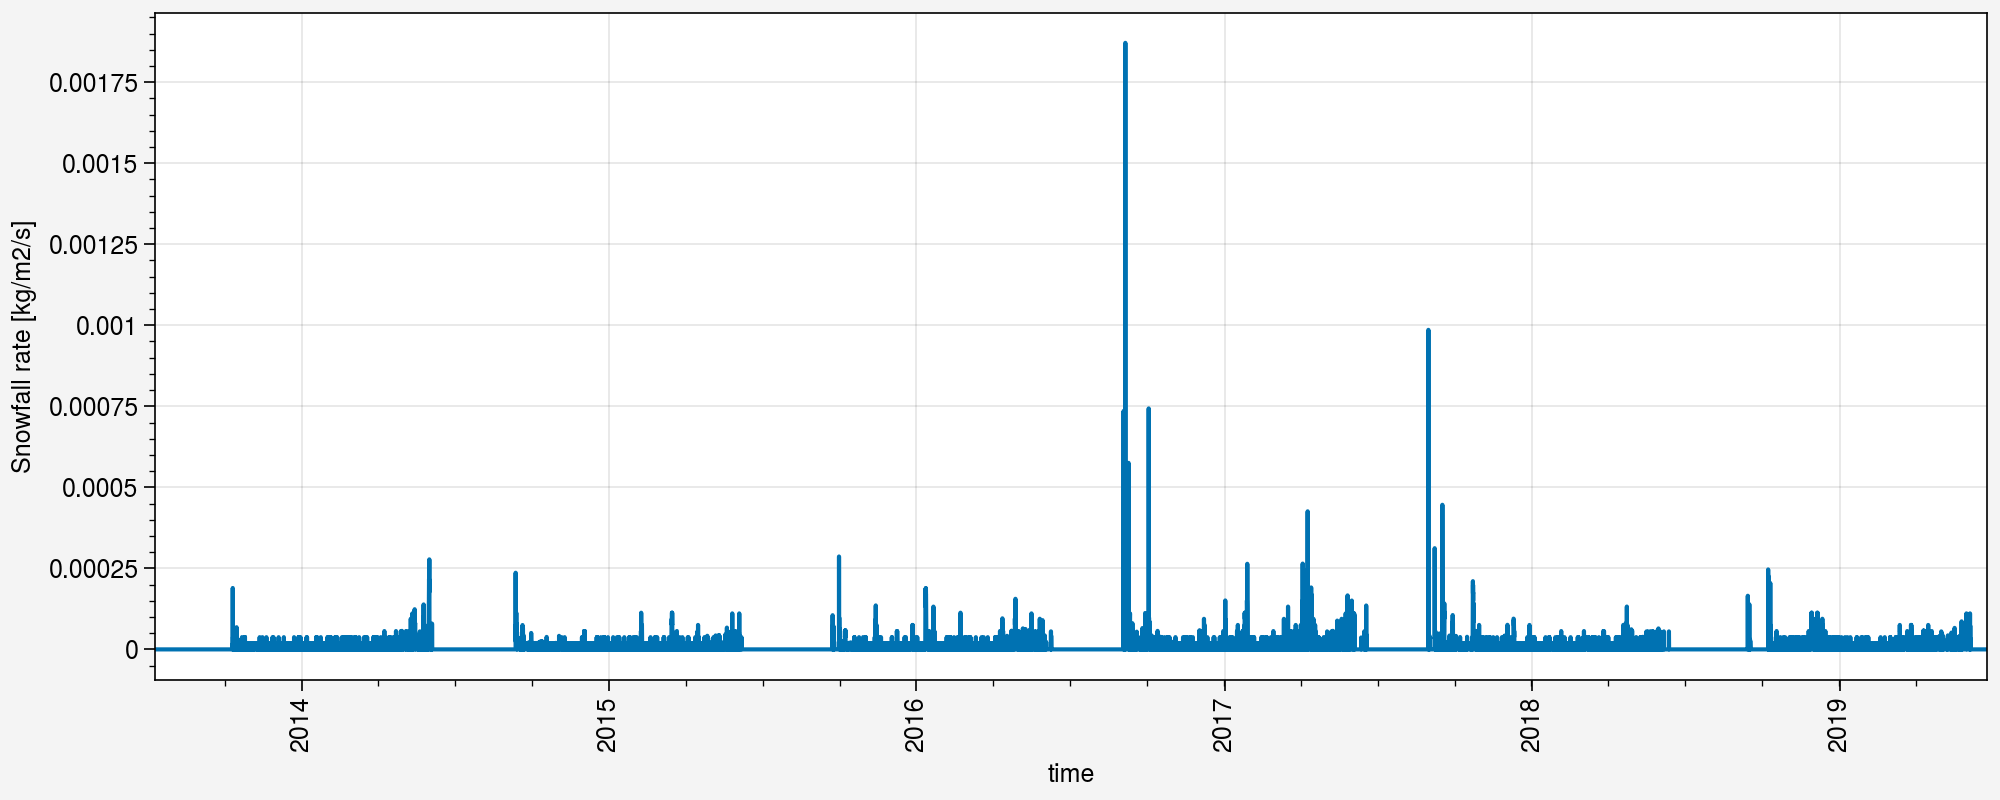

In [205]:
%matplotlib inline
pplt.subplots(figsize=(10,4))
ds.Snowf.plot()

## Keep going

In [206]:
ds.time.encoding

{'dtype': dtype('int64'),
 'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/met_insitu_byl_2013_2019.nc',
 'original_shape': (52202,),
 'units': 'hours since 2013-07-11 09:00:00',
 'calendar': 'proleptic_gregorian'}

In [207]:
# Check if there are leap years
ds.sel(time='2016-02')

<xarray.Dataset> Size: 50kB
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-02-01 ... 2016-02-29T23:00:00
Data variables:
    Wind     (time) float64 6kB ...
    Tair     (time) float64 6kB -38.94 -39.86 -39.01 ... -27.46 -29.23 -26.26
    Qair     (time) float64 6kB ...
    LWdown   (time) float64 6kB ...
    SWdown   (time) float64 6kB ...
    Psurf    (time) float64 6kB ...
    Rainf    (time) float64 6kB ...
    Snowf    (time) float64 6kB 0.0 0.0 0.0 1.887e-05 0.0 ... 0.0 0.0 0.0 0.0

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [208]:
ds_30min = ds.resample(time='30min').interpolate()
ds_30min

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 104403)
Coordinates:
  * time     (time) datetime64[ns] 835kB 2013-07-11T09:00:00 ... 2019-06-25T1...
Data variables:
    Wind     (time) float64 835kB 1.53 1.468 1.405 1.713 ... 1.45 1.292 1.135
    Tair     (time) float64 835kB 6.82 6.889 6.958 7.941 ... 10.43 9.809 9.186
    Qair     (time) float64 835kB 0.005626 0.005593 ... 0.004688 0.004424
    LWdown   (time) float64 835kB 308.9 304.3 299.7 294.6 ... 253.9 255.9 257.9
    SWdown   (time) float64 835kB 250.9 280.7 310.5 491.6 ... 580.8 629.9 679.0
    Psurf    (time) float64 835kB 1.002e+05 1.002e+05 ... 1.015e+05 1.015e+05
    Rainf    (time) float64 835kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Snowf    (time) float64 835kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Extend beginning and the end of the forcing
Because CLASSIC only accept full years (will need to be removed for analyses)

In [209]:
time_ext = pd.date_range(
    pd.to_datetime(ds_30min.time.dt.year[0], format='%Y'), 
    str(ds_30min.time.dt.year[-1].values.item(0))+'-12-31 23:30:00',
    freq='30min'
)
time_ext

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 00:30:00',
               '2013-01-01 01:00:00', '2013-01-01 01:30:00',
               '2013-01-01 02:00:00', '2013-01-01 02:30:00',
               '2013-01-01 03:00:00', '2013-01-01 03:30:00',
               '2013-01-01 04:00:00', '2013-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', length=122688, freq='30T')

In [210]:
ds_30min_ext = ds_30min.reindex(time=time_ext)
ds_30min_ext

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 122688)
Coordinates:
  * time     (time) datetime64[ns] 982kB 2013-01-01 ... 2019-12-31T23:30:00
Data variables:
    Wind     (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    Tair     (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    Qair     (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    LWdown   (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    SWdown   (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    Psurf    (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    Rainf    (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan
    Snowf    (time) float64 982kB nan nan nan nan nan ... nan nan nan nan nan

In [211]:
# ds_30min    : XXXXXXXXXXXXXXXXXXXXXXXXXXXX........... i_start_next_year ....... i_end_next_year
# ds_30min_ext: 1rst jan .... i_before_start

i_before_start = ds_30min_ext.sel(time=slice(None,ds_30min.time[0])).time.size - 1 
i_start_next_year = ds_30min.sel(time=slice(None, year_start)).time.size
i_end_next_year = i_start_next_year + i_before_start

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][:i_before_start].size,
    ds_30min['Wind'][i_start_next_year:i_end_next_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][:i_before_start] = ds_30min[key][i_start_next_year:i_end_next_year].values

In [212]:
# ds_30min    : i_start_prev_year ....... i_end_prev_year.......XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# ds_30min_ext: ............................................... i_after_end.......... 31 dec

i_after_end = ds_30min_ext.sel(time=slice(ds_30min.time[-1]+1, None)).time.size
i_end_prev_year = ds_30min.time.sel(time=slice(year_end, None)).time.size
i_start_prev_year = i_end_prev_year + i_after_end

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][-i_after_end:].size,
    ds_30min['Wind'][-i_start_prev_year:-i_end_prev_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][-i_after_end:] = ds_30min[key][-i_start_prev_year:-i_end_prev_year].values

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

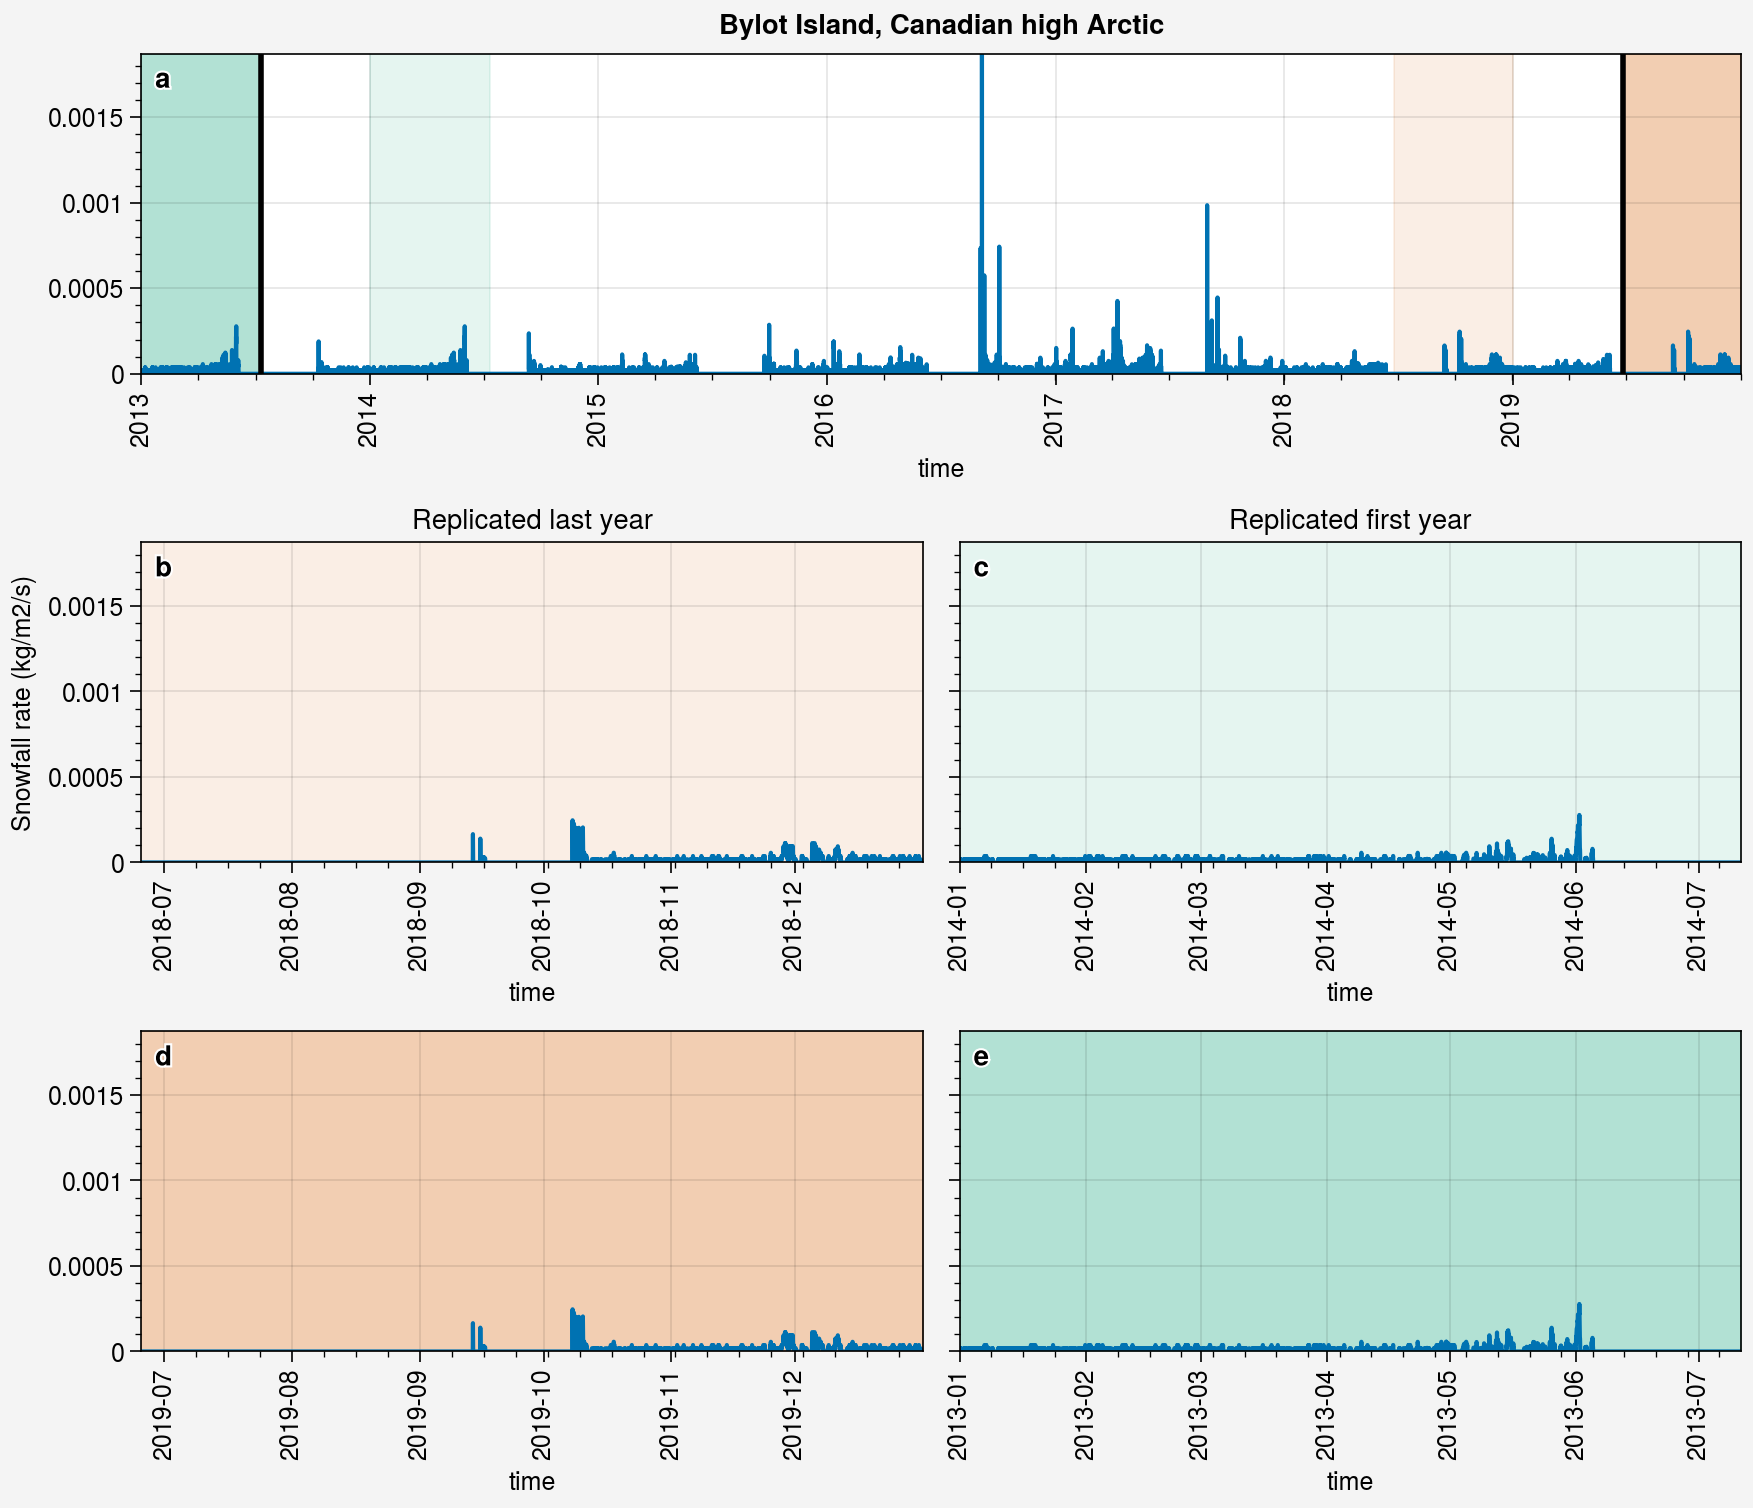

In [215]:
%matplotlib inline
fig, axs = pplt.subplots([[1, 1], [2, 3], [4, 5]], refaspect=5, refwidth=8, sharex=0)

key = 'Snowf'

axs[0].plot(ds_30min_ext[key])

axs[0].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[0].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs[0].axvline(ds_30min[key][0].time.values, lw=2, ls='-', color='k')
axs[0].axvline(ds_30min[key][-1].time.values, lw=2, ls='-', color='k')

axs[2].format(title='Replicated first year')
axs[4].plot(ds_30min_ext[key][:i_before_start])
axs[4].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)
axs[2].plot(ds_30min[key][i_start_next_year:i_end_next_year])
axs[2].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[1].format(title='Replicated last year')
axs[3].plot(ds_30min_ext[key][-i_after_end:])
axs[3].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)
axs[1].plot(ds_30min[key][-i_start_prev_year:-i_end_prev_year])
axs[1].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs.format(abc=True, abcloc='ul')
fig.suptitle(site_longname)


### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [216]:
ds_30min_ext.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_ext_snd'+year_start+'_'+year_end+'.nc')

In [217]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_ext_snd{year_start}_{year_end}.nc {path_tmp}/met_insitu_{site}_30min_ext_snd{year_start}_{year_end}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 981504 values from 8 variables over 122688 timesteps [11.61s 1691MB]


## Open the new file with absolute time

In [218]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_ext_snd'+year_start+'_'+year_end+'_a.nc')
ds

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 122688)
Coordinates:
  * time     (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Data variables:
    Wind     (time) float64 982kB ...
    Tair     (time) float64 982kB ...
    Qair     (time) float64 982kB ...
    LWdown   (time) float64 982kB ...
    SWdown   (time) float64 982kB ...
    Psurf    (time) float64 982kB ...
    Rainf    (time) float64 982kB ...
    Snowf    (time) float64 982kB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 07 09:18:04 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [219]:
ds.time

<xarray.DataArray 'time' (time: 122688)> Size: 982kB
array([20130101.      , 20130101.020833, 20130101.041667, ..., 20191231.9375  ,
       20191231.958333, 20191231.979167])
Coordinates:
  * time     (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [220]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 122688, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon      (lon) float64 8B -80.0
  * lat      (lat) float64 8B 73.15
Data variables:
    Wind     (time, lat, lon) float64 982kB 0.134 0.105 0.076 ... 0.369 0.271
    Tair     (time, lat, lon) float64 982kB -39.72 -39.49 ... -28.13 -28.01
    Qair     (time, lat, lon) float64 982kB 7.51e-05 7.665e-05 ... 0.000275
    LWdown   (time, lat, lon) float64 982kB 162.2 162.3 162.3 ... 170.2 166.9
    SWdown   (time, lat, lon) float64 982kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Psurf    (time, lat, lon) float64 982kB 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf    (time, lat, lon) float64 982kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 982kB 0.0 0.0 0.0 ... 0.0 0.0 9.433e-06
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 07 09:18:04 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

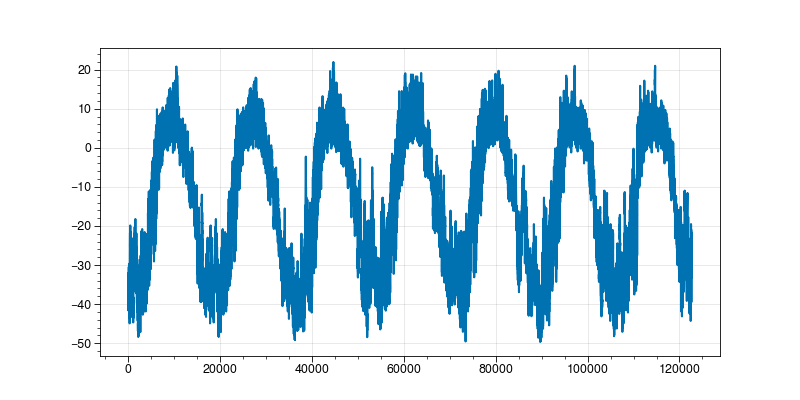

In [221]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

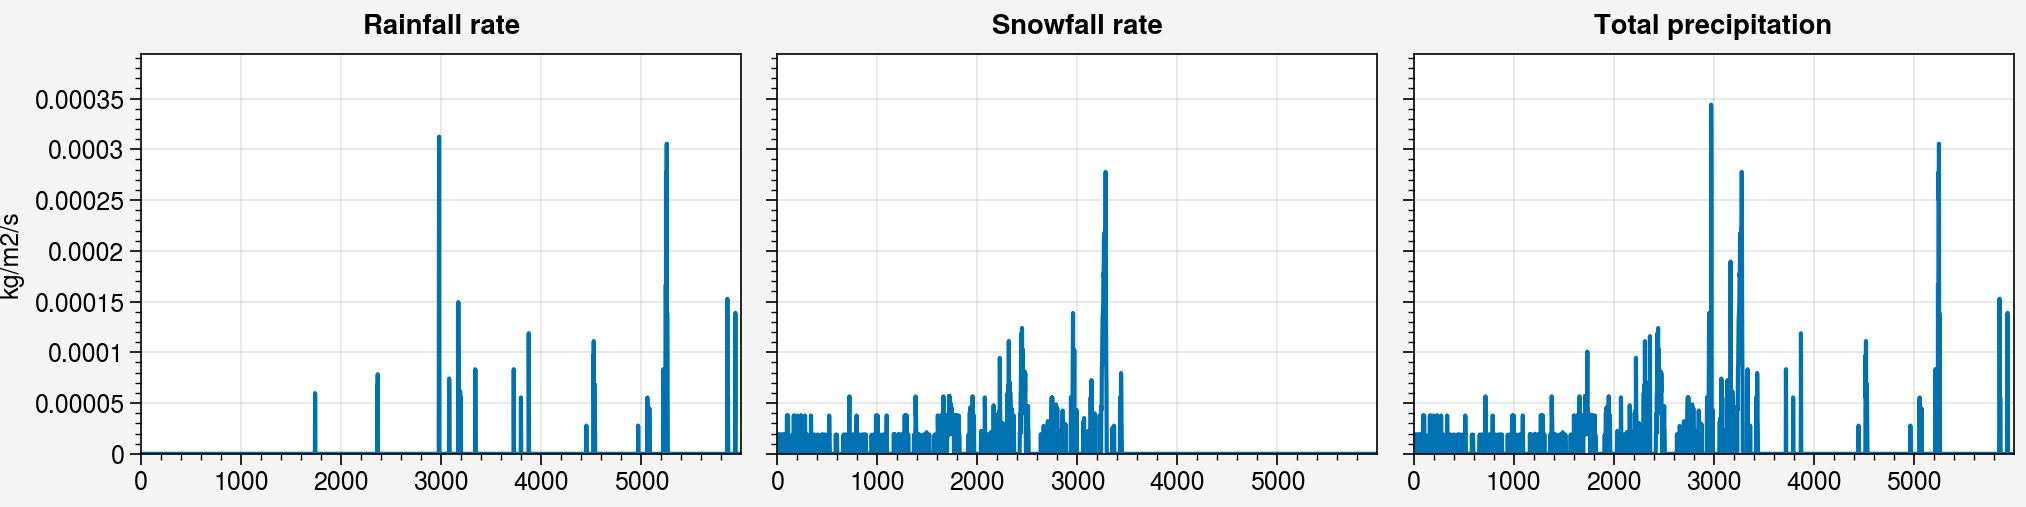

In [222]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 2000*2
i_end = 5000*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [223]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset> Size: 10MB
Dimensions:    (time: 122688, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 982kB 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon        (lon) float64 8B -80.0
  * lat        (lat) float64 8B 73.15
Data variables:
    Wind       (time, lat, lon) float64 982kB 0.134 0.105 0.076 ... 0.369 0.271
    Tair       (time, lat, lon) float64 982kB -39.72 -39.49 ... -28.13 -28.01
    Qair       (time, lat, lon) float64 982kB 7.51e-05 7.665e-05 ... 0.000275
    LWdown     (time, lat, lon) float64 982kB 162.2 162.3 162.3 ... 170.2 166.9
    SWdown     (time, lat, lon) float64 982kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Psurf      (time, lat, lon) float64 982kB 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf      (time, lat, lon) float64 982kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 982kB 0.0 0.0 0.0 ... 0.0 0.0 9.433e-06
    TotPrecip  (time, lat, lon) float64 982kB 0.0 0.0 0.0 ... 0.0 0.0 9.433e-06
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 07 09:18:04 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [226]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_ext_snd'+year_start+'_'+year_end+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_ext_snd'+year_start+'_'+year_end+'_'+key+'.nc')

In [227]:
!ls {path_out}

met_insitu_byl_0.4xERA5precip_30min_2014_2018_Snowf.nc
met_insitu_byl_0.4xERA5precip_30min_2014_2018_TotPrecip.nc
met_insitu_byl_0.5xERA5precip_30min_2014_2018_Snowf.nc
met_insitu_byl_0.5xERA5precip_30min_2014_2018_TotPrecip.nc
met_insitu_byl_0.6xERA5precip_30min_2014_2018_Snowf.nc
met_insitu_byl_0.6xERA5precip_30min_2014_2018_TotPrecip.nc
met_insitu_byl_0.7xERA5precip_30min_2014_2018_Snowf.nc
met_insitu_byl_0.7xERA5precip_30min_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
me

In [203]:
!ls {path_out_CLASSIC}

met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
met_insitu_byl_2014_2018_SWdown.nc
met_insitu_byl_2014_2018_Tair.nc
met_insitu_byl_2014_2018_TotPrecip.nc
met_insitu_byl_2014_2018_Wind.nc
met_insitu_byl_30min_2014_2018_LWdown.nc
met_insitu_byl_30min_2014_2018_Psurf.nc
met_insitu_byl_30min_2014_2018_Qair.nc
met_insitu_byl_30min_2014_2018_Rainf.nc
met_insitu_byl_30min_2014_2018_Snowf.nc
met_insitu_byl_30min_2014_2018_SWdown.nc
met_insitu_byl_30min_2014_2018_Tair.nc
met_insitu_byl_30min_2014_2018_TotPreci

### Keep the same initial files from Ref run (but redo spinup)

In [208]:
# path_init = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site
# exp2 = 'peat_30min_ext'
# # exp2 = 'Ref_30min_ext'
# !cp {path_init}/{site}_init_spinup_Ref.nc {path_init}/{site}_init_spinup_{exp2}.nc
# !cp {path_init}/rsfile_spinup_Ref.nc {path_init}/rsfile_spinup_{exp2}.nc

In [209]:
!mkdir /home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/{site}/spinup_{exp2}